# Language Model analysis

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import Word2Vec
from gensim import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# embedding models, base model
#model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/models/all_books/w2v_005/w2v_words.model"
model_path = "./LMs/embedding_model_scratch_corrected.model"
w2v_corrected = Word2Vec.load(model_path)

2019-11-20 22:59:19,757 : INFO : loading Word2Vec object from ./LMs/embedding_model_scratch_corrected.model
2019-11-20 22:59:20,221 : INFO : loading wv recursively from ./LMs/embedding_model_scratch_corrected.model.wv.* with mmap=None
2019-11-20 22:59:20,222 : INFO : loading vectors from ./LMs/embedding_model_scratch_corrected.model.wv.vectors.npy with mmap=None
2019-11-20 22:59:20,342 : INFO : setting ignored attribute vectors_norm to None
2019-11-20 22:59:20,343 : INFO : loading vocabulary recursively from ./LMs/embedding_model_scratch_corrected.model.vocabulary.* with mmap=None
2019-11-20 22:59:20,344 : INFO : loading trainables recursively from ./LMs/embedding_model_scratch_corrected.model.trainables.* with mmap=None
2019-11-20 22:59:20,345 : INFO : loading syn1neg from ./LMs/embedding_model_scratch_corrected.model.trainables.syn1neg.npy with mmap=None
2019-11-20 22:59:20,468 : INFO : setting ignored attribute cum_table to None
2019-11-20 22:59:20,469 : INFO : loaded ./LMs/embeddin

In [3]:
def found_neighbors(myrow, embedding, colname='vocab', topn=1):
    try:
        vocab_neigh = embedding.wv.most_similar([myrow['vocab']], topn=topn)
        return list(np.array(vocab_neigh)[:, 0])
    except KeyError:
        return []

In [12]:
def jaccard_similarity_df(myrow, colname_1, colname_2, num_items=False, make_lowercase=True):
    """
    Jaccard similarity between two documents (e.g., OCR and Human) on flattened list of words
    """
    if not num_items:
        list1 = myrow[colname_1]
        list2 = myrow[colname_2]
    else:
        list1 = myrow[colname_1][:num_items]
        list2 = myrow[colname_2][:num_items]
    if make_lowercase:
        list1 = [x.lower() for x in list1]
        list2 = [x.lower() for x in list2]
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [5]:
words_corrected = []
for item in w2v_corrected.wv.vocab:
    words_corrected.append([item, int(w2v_corrected.wv.vocab[item].count)])

In [6]:
pd_words = pd.DataFrame(words_corrected, columns=['vocab', 'count'])

In [7]:
pd_words = pd_words.sort_values(by=['count'], ascending=False)
print("size: {}".format(len(pd_words)))
pd_words.head()

size: 179735


,vocab,count
57,",",860225
24,.,831221
21,the,736361
5,of,351214
110,and,291173


In [8]:
pd2search = pd_words[0:1000]
pd2search

,vocab,count
57,",",860225
24,.,831221
21,the,736361
5,of,351214
110,and,291173
...,...,...
2483,matches,1142
8638,cape,1140
2883,matters,1139
265,prince,1139


# Quality bands 1, 2

## Create list of words and their frequencies in the corrected set

In [29]:
neigh_jaccard_bands_1_2 = []

for i_model in range(0, 50):

    w2v_em_corr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_corr_qual_1_2_%05i.model' % i_model)
    w2v_em_ocr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_ocr_qual_1_2_%05i.model' % i_model)

    #for topn in [1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    for topn in [50000]:
        print("topn: {}".format(topn))
        t1 = time.time()

        pd2search = pd_words[0:1000]
        pd2search['w2v_em_corr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_corr_qual_1_2, 
                                                                                   'vocab', 
                                                                                   topn], axis=1)
        print("corr: {}".format(time.time() - t1))
        pd2search['w2v_em_ocr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_ocr_qual_1_2,
                                                                                  'vocab', 
                                                                                  topn], axis=1)
        print("ocr: {}".format(time.time() - t1))

    mytopn_range = [1, 2, 5, 
                    10, 20, 50, 
                    100, 200, 500, 
                    1000, 2000, 5000, 
                    10000, 20000, 50000]
    for mytopn in mytopn_range:
        pd2search['jaccard_qual_1_2'] = \
            pd2search.apply(jaccard_similarity_df, 
                            args=['w2v_em_corr_qual_1_2', "w2v_em_ocr_qual_1_2", mytopn], 
                            axis=1)

        neigh_jaccard_bands_1_2.append(
            [mytopn, 
             pd2search['jaccard_qual_1_2'].mean(), 
             pd2search['jaccard_qual_1_2'].std(),
             i_model
            ])
    print("total: {}".format(time.time() - t1))
    np.save("neigh_jaccard_bands_1_2.npy", np.array(neigh_jaccard_bands_1_2))

neigh_jaccard_bands_1_2 = np.array(neigh_jaccard_bands_1_2)

2019-11-21 00:15:34,093 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00000.model
2019-11-21 00:15:35,030 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00000.model.wv.* with mmap=None
2019-11-21 00:15:35,031 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00000.model.wv.vectors.npy with mmap=None
2019-11-21 00:15:35,642 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 00:15:35,643 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00000.model.vocabulary.* with mmap=None
2019-11-21 00:15:35,643 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00000.model.trainables.* with mmap=None
2019-11-21 00:15:35,644 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00000.model.trainables.syn1neg.npy with mmap=None
2019-11-21 00:15:36,095 : INFO : setting ignored attribute cum_table to None
2019-11-21 00:15:36,096 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_0

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 00:19:44,673 : INFO : precomputing L2-norms of word weight vectors


corr: 225.4920597076416


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 449.3939018249512


2019-11-21 00:24:27,673 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00001.model


total: 508.4501156806946


2019-11-21 00:25:18,316 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00001.model.wv.* with mmap=None
2019-11-21 00:25:18,327 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00001.model.wv.vectors.npy with mmap=None
2019-11-21 00:25:18,907 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 00:25:18,909 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00001.model.vocabulary.* with mmap=None
2019-11-21 00:25:18,911 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00001.model.trainables.* with mmap=None
2019-11-21 00:25:18,912 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00001.model.trainables.syn1neg.npy with mmap=None
2019-11-21 00:25:19,488 : INFO : setting ignored attribute cum_table to None
2019-11-21 00:25:19,489 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00001.model
2019-11-21 00:25:21,579 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


2019-11-21 00:26:20,254 : INFO : precomputing L2-norms of word weight vectors
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 00:30:01,793 : INFO : precomputing L2-norms of word weight vectors


corr: 236.33311295509338


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 454.0198860168457


2019-11-21 00:34:33,876 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00002.model


total: 508.39568996429443


2019-11-21 00:35:27,668 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00002.model.wv.* with mmap=None
2019-11-21 00:35:27,671 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00002.model.wv.vectors.npy with mmap=None
2019-11-21 00:35:28,261 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 00:35:28,262 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00002.model.vocabulary.* with mmap=None
2019-11-21 00:35:28,263 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00002.model.trainables.* with mmap=None
2019-11-21 00:35:28,263 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00002.model.trainables.syn1neg.npy with mmap=None
2019-11-21 00:35:28,799 : INFO : setting ignored attribute cum_table to None
2019-11-21 00:35:28,801 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00002.model
2019-11-21 00:35:31,027 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


2019-11-21 00:36:29,164 : INFO : precomputing L2-norms of word weight vectors
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 00:40:02,740 : INFO : precomputing L2-norms of word weight vectors


corr: 230.911719083786


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 445.8209972381592


2019-11-21 00:44:31,610 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00003.model


total: 499.7120041847229


2019-11-21 00:45:28,954 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00003.model.wv.* with mmap=None
2019-11-21 00:45:28,961 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00003.model.wv.vectors.npy with mmap=None
2019-11-21 00:45:29,550 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 00:45:29,551 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00003.model.vocabulary.* with mmap=None
2019-11-21 00:45:29,552 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00003.model.trainables.* with mmap=None
2019-11-21 00:45:29,553 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00003.model.trainables.syn1neg.npy with mmap=None
2019-11-21 00:45:30,107 : INFO : setting ignored attribute cum_table to None
2019-11-21 00:45:30,108 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00003.model
2019-11-21 00:45:32,569 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 00:50:05,815 : INFO : precomputing L2-norms of word weight vectors


corr: 232.7473850250244


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 451.8002140522003


2019-11-21 00:54:41,695 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00004.model


total: 508.5914931297302


2019-11-21 00:55:33,266 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00004.model.wv.* with mmap=None
2019-11-21 00:55:33,271 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00004.model.wv.vectors.npy with mmap=None
2019-11-21 00:55:33,909 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 00:55:33,909 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00004.model.vocabulary.* with mmap=None
2019-11-21 00:55:33,910 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00004.model.trainables.* with mmap=None
2019-11-21 00:55:33,911 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00004.model.trainables.syn1neg.npy with mmap=None
2019-11-21 00:55:34,468 : INFO : setting ignored attribute cum_table to None
2019-11-21 00:55:34,469 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00004.model
2019-11-21 00:55:36,741 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 01:00:12,950 : INFO : precomputing L2-norms of word weight vectors


corr: 235.52997303009033


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 455.29249119758606


2019-11-21 01:04:49,284 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00005.model


total: 511.83160400390625


2019-11-21 01:05:41,622 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00005.model.wv.* with mmap=None
2019-11-21 01:05:41,629 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00005.model.wv.vectors.npy with mmap=None
2019-11-21 01:05:42,359 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 01:05:42,360 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00005.model.vocabulary.* with mmap=None
2019-11-21 01:05:42,361 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00005.model.trainables.* with mmap=None
2019-11-21 01:05:42,361 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00005.model.trainables.syn1neg.npy with mmap=None
2019-11-21 01:05:43,029 : INFO : setting ignored attribute cum_table to None
2019-11-21 01:05:43,030 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00005.model
2019-11-21 01:05:45,295 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 01:10:18,609 : INFO : precomputing L2-norms of word weight vectors


corr: 232.41169381141663


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 450.83373379707336


2019-11-21 01:14:51,650 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00006.model


total: 505.41071701049805


2019-11-21 01:15:45,023 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00006.model.wv.* with mmap=None
2019-11-21 01:15:45,028 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00006.model.wv.vectors.npy with mmap=None
2019-11-21 01:15:45,848 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 01:15:45,849 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00006.model.vocabulary.* with mmap=None
2019-11-21 01:15:45,849 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00006.model.trainables.* with mmap=None
2019-11-21 01:15:45,850 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00006.model.trainables.syn1neg.npy with mmap=None
2019-11-21 01:15:46,432 : INFO : setting ignored attribute cum_table to None
2019-11-21 01:15:46,433 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00006.model
2019-11-21 01:15:48,782 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 01:20:23,121 : INFO : precomputing L2-norms of word weight vectors


corr: 233.85435009002686


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 452.2768692970276


2019-11-21 01:24:57,897 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00007.model


total: 508.56683015823364


2019-11-21 01:25:57,356 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00007.model.wv.* with mmap=None
2019-11-21 01:25:57,362 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00007.model.wv.vectors.npy with mmap=None
2019-11-21 01:25:58,074 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 01:25:58,076 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00007.model.vocabulary.* with mmap=None
2019-11-21 01:25:58,079 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00007.model.trainables.* with mmap=None
2019-11-21 01:25:58,079 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00007.model.trainables.syn1neg.npy with mmap=None
2019-11-21 01:25:58,697 : INFO : setting ignored attribute cum_table to None
2019-11-21 01:25:58,698 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00007.model
2019-11-21 01:26:00,961 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 01:30:40,569 : INFO : precomputing L2-norms of word weight vectors


corr: 237.8191888332367


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 458.8212468624115


2019-11-21 01:35:20,670 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00008.model


total: 517.8826990127563


2019-11-21 01:36:16,003 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00008.model.wv.* with mmap=None
2019-11-21 01:36:16,009 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00008.model.wv.vectors.npy with mmap=None
2019-11-21 01:36:16,739 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 01:36:16,739 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00008.model.vocabulary.* with mmap=None
2019-11-21 01:36:16,741 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00008.model.trainables.* with mmap=None
2019-11-21 01:36:16,742 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00008.model.trainables.syn1neg.npy with mmap=None
2019-11-21 01:36:17,352 : INFO : setting ignored attribute cum_table to None
2019-11-21 01:36:17,353 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00008.model
2019-11-21 01:36:19,733 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


2019-11-21 01:36:39,888 : INFO : precomputing L2-norms of word weight vectors
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 01:40:14,923 : INFO : precomputing L2-norms of word weight vectors


corr: 230.66552591323853


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 486.21240305900574


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2019-11-21 01:45:25,827 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00009.model


total: 541.5621249675751


2019-11-21 01:46:19,215 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00009.model.wv.* with mmap=None
2019-11-21 01:46:19,219 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00009.model.wv.vectors.npy with mmap=None
2019-11-21 01:46:19,904 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 01:46:19,904 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00009.model.vocabulary.* with mmap=None
2019-11-21 01:46:19,905 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00009.model.trainables.* with mmap=None
2019-11-21 01:46:19,906 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00009.model.trainables.syn1neg.npy with mmap=None
2019-11-21 01:46:20,508 : INFO : setting ignored attribute cum_table to None
2019-11-21 01:46:20,510 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00009.model
2019-11-21 01:46:22,507 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 01:50:56,453 : INFO : precomputing L2-norms of word weight vectors


corr: 233.11754488945007


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 452.5065200328827


2019-11-21 01:55:30,934 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00010.model


total: 507.5495181083679


2019-11-21 01:56:23,060 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00010.model.wv.* with mmap=None
2019-11-21 01:56:23,065 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00010.model.wv.vectors.npy with mmap=None
2019-11-21 01:56:23,815 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 01:56:23,816 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00010.model.vocabulary.* with mmap=None
2019-11-21 01:56:23,817 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00010.model.trainables.* with mmap=None
2019-11-21 01:56:23,818 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00010.model.trainables.syn1neg.npy with mmap=None
2019-11-21 01:56:24,477 : INFO : setting ignored attribute cum_table to None
2019-11-21 01:56:24,479 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00010.model
2019-11-21 01:56:26,734 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 02:01:02,826 : INFO : precomputing L2-norms of word weight vectors


corr: 235.66244268417358


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 455.8551518917084


2019-11-21 02:05:39,106 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00011.model


total: 511.8957839012146


2019-11-21 02:06:37,780 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00011.model.wv.* with mmap=None
2019-11-21 02:06:37,786 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00011.model.wv.vectors.npy with mmap=None
2019-11-21 02:06:38,537 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 02:06:38,538 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00011.model.vocabulary.* with mmap=None
2019-11-21 02:06:38,540 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00011.model.trainables.* with mmap=None
2019-11-21 02:06:38,542 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00011.model.trainables.syn1neg.npy with mmap=None
2019-11-21 02:06:39,155 : INFO : setting ignored attribute cum_table to None
2019-11-21 02:06:39,155 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00011.model
2019-11-21 02:06:41,421 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 02:11:15,634 : INFO : precomputing L2-norms of word weight vectors


corr: 234.34610891342163


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 452.24487495422363


2019-11-21 02:15:44,293 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00012.model


total: 502.9406280517578


2019-11-21 02:16:36,731 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00012.model.wv.* with mmap=None
2019-11-21 02:16:36,742 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00012.model.wv.vectors.npy with mmap=None
2019-11-21 02:16:37,513 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 02:16:37,514 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00012.model.vocabulary.* with mmap=None
2019-11-21 02:16:37,515 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00012.model.trainables.* with mmap=None
2019-11-21 02:16:37,518 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00012.model.trainables.syn1neg.npy with mmap=None
2019-11-21 02:16:38,146 : INFO : setting ignored attribute cum_table to None
2019-11-21 02:16:38,148 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00012.model
2019-11-21 02:16:40,214 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 02:21:13,466 : INFO : precomputing L2-norms of word weight vectors


corr: 233.57773685455322


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 452.18661665916443


2019-11-21 02:25:45,564 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00013.model


total: 505.6244328022003


2019-11-21 02:26:37,685 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00013.model.wv.* with mmap=None
2019-11-21 02:26:37,695 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00013.model.wv.vectors.npy with mmap=None
2019-11-21 02:26:38,471 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 02:26:38,472 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00013.model.vocabulary.* with mmap=None
2019-11-21 02:26:38,473 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00013.model.trainables.* with mmap=None
2019-11-21 02:26:38,474 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00013.model.trainables.syn1neg.npy with mmap=None
2019-11-21 02:26:39,052 : INFO : setting ignored attribute cum_table to None
2019-11-21 02:26:39,052 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00013.model
2019-11-21 02:26:41,420 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 02:31:16,071 : INFO : precomputing L2-norms of word weight vectors


corr: 235.1776578426361


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 455.2048077583313


2019-11-21 02:35:50,385 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00014.model


total: 509.4552619457245


2019-11-21 02:35:51,738 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00014.model.wv.* with mmap=None
2019-11-21 02:35:51,742 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00014.model.wv.vectors.npy with mmap=None
2019-11-21 02:35:52,827 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 02:35:52,829 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00014.model.vocabulary.* with mmap=None
2019-11-21 02:35:52,832 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00014.model.trainables.* with mmap=None
2019-11-21 02:35:52,832 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00014.model.trainables.syn1neg.npy with mmap=None
2019-11-21 02:35:53,508 : INFO : setting ignored attribute cum_table to None
2019-11-21 02:35:53,510 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00014.model
2019-11-21 02:35:55,499 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 02:41:15,778 : INFO : precomputing L2-norms of word weight vectors


corr: 233.7732651233673


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 451.7629520893097


2019-11-21 02:45:46,671 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00015.model


total: 504.6136631965637


2019-11-21 02:46:39,123 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00015.model.wv.* with mmap=None
2019-11-21 02:46:39,130 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00015.model.wv.vectors.npy with mmap=None
2019-11-21 02:46:39,846 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 02:46:39,848 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00015.model.vocabulary.* with mmap=None
2019-11-21 02:46:39,848 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00015.model.trainables.* with mmap=None
2019-11-21 02:46:39,849 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00015.model.trainables.syn1neg.npy with mmap=None
2019-11-21 02:46:40,491 : INFO : setting ignored attribute cum_table to None
2019-11-21 02:46:40,492 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00015.model
2019-11-21 02:46:42,959 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 02:51:21,347 : INFO : precomputing L2-norms of word weight vectors


corr: 236.9676330089569


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 454.69381284713745


2019-11-21 02:55:51,387 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00016.model


total: 506.93261885643005


2019-11-21 02:56:43,844 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00016.model.wv.* with mmap=None
2019-11-21 02:56:43,848 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00016.model.wv.vectors.npy with mmap=None
2019-11-21 02:56:44,567 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 02:56:44,568 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00016.model.vocabulary.* with mmap=None
2019-11-21 02:56:44,569 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00016.model.trainables.* with mmap=None
2019-11-21 02:56:44,569 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00016.model.trainables.syn1neg.npy with mmap=None
2019-11-21 02:56:45,255 : INFO : setting ignored attribute cum_table to None
2019-11-21 02:56:45,256 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00016.model
2019-11-21 02:56:47,518 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


2019-11-21 02:57:43,315 : INFO : precomputing L2-norms of word weight vectors
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 03:01:25,003 : INFO : precomputing L2-norms of word weight vectors


corr: 236.01181197166443


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.16574597358704


2019-11-21 03:06:04,860 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00017.model


total: 515.8182728290558


2019-11-21 03:06:57,504 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00017.model.wv.* with mmap=None
2019-11-21 03:06:57,509 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00017.model.wv.vectors.npy with mmap=None
2019-11-21 03:06:58,333 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 03:06:58,335 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00017.model.vocabulary.* with mmap=None
2019-11-21 03:06:58,337 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00017.model.trainables.* with mmap=None
2019-11-21 03:06:58,338 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00017.model.trainables.syn1neg.npy with mmap=None
2019-11-21 03:06:58,924 : INFO : setting ignored attribute cum_table to None
2019-11-21 03:06:58,925 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00017.model
2019-11-21 03:07:01,202 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 03:11:37,647 : INFO : precomputing L2-norms of word weight vectors


corr: 235.44400596618652


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 454.3758280277252


2019-11-21 03:16:12,364 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00018.model


total: 510.1179130077362


2019-11-21 03:17:05,327 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00018.model.wv.* with mmap=None
2019-11-21 03:17:05,330 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00018.model.wv.vectors.npy with mmap=None
2019-11-21 03:17:06,152 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 03:17:06,153 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00018.model.vocabulary.* with mmap=None
2019-11-21 03:17:06,155 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00018.model.trainables.* with mmap=None
2019-11-21 03:17:06,156 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00018.model.trainables.syn1neg.npy with mmap=None
2019-11-21 03:17:06,713 : INFO : setting ignored attribute cum_table to None
2019-11-21 03:17:06,714 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00018.model
2019-11-21 03:17:09,050 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 03:21:43,784 : INFO : precomputing L2-norms of word weight vectors


corr: 234.68637418746948


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 453.9734399318695


2019-11-21 03:26:20,224 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00019.model


total: 511.0754601955414


2019-11-21 03:27:12,749 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00019.model.wv.* with mmap=None
2019-11-21 03:27:12,755 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00019.model.wv.vectors.npy with mmap=None
2019-11-21 03:27:13,541 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 03:27:13,542 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00019.model.vocabulary.* with mmap=None
2019-11-21 03:27:13,542 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00019.model.trainables.* with mmap=None
2019-11-21 03:27:13,543 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00019.model.trainables.syn1neg.npy with mmap=None
2019-11-21 03:27:14,242 : INFO : setting ignored attribute cum_table to None
2019-11-21 03:27:14,244 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00019.model
2019-11-21 03:27:16,386 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 03:31:52,285 : INFO : precomputing L2-norms of word weight vectors


corr: 236.1179392337799


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.8496000766754


2019-11-21 03:36:30,221 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00020.model


total: 513.9689021110535


2019-11-21 03:37:23,627 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00020.model.wv.* with mmap=None
2019-11-21 03:37:23,635 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00020.model.wv.vectors.npy with mmap=None
2019-11-21 03:37:24,495 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 03:37:24,496 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00020.model.vocabulary.* with mmap=None
2019-11-21 03:37:24,497 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00020.model.trainables.* with mmap=None
2019-11-21 03:37:24,497 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00020.model.trainables.syn1neg.npy with mmap=None
2019-11-21 03:37:25,143 : INFO : setting ignored attribute cum_table to None
2019-11-21 03:37:25,144 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00020.model
2019-11-21 03:37:27,511 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 03:42:05,295 : INFO : precomputing L2-norms of word weight vectors


corr: 235.65741205215454


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 453.7037510871887


2019-11-21 03:46:39,821 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00021.model


total: 510.0455400943756


2019-11-21 03:47:32,740 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00021.model.wv.* with mmap=None
2019-11-21 03:47:32,746 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00021.model.wv.vectors.npy with mmap=None
2019-11-21 03:47:33,477 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 03:47:33,478 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00021.model.vocabulary.* with mmap=None
2019-11-21 03:47:33,479 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00021.model.trainables.* with mmap=None
2019-11-21 03:47:33,480 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00021.model.trainables.syn1neg.npy with mmap=None
2019-11-21 03:47:34,084 : INFO : setting ignored attribute cum_table to None
2019-11-21 03:47:34,085 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00021.model
2019-11-21 03:47:36,460 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 03:52:11,456 : INFO : precomputing L2-norms of word weight vectors


corr: 234.5012879371643


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 453.8259310722351


2019-11-21 03:56:48,956 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00022.model


total: 511.9550030231476


2019-11-21 03:56:50,193 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00022.model.wv.* with mmap=None
2019-11-21 03:56:50,197 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00022.model.wv.vectors.npy with mmap=None
2019-11-21 03:56:50,903 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 03:56:50,904 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00022.model.vocabulary.* with mmap=None
2019-11-21 03:56:50,906 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00022.model.trainables.* with mmap=None
2019-11-21 03:56:50,908 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00022.model.trainables.syn1neg.npy with mmap=None
2019-11-21 03:56:51,573 : INFO : setting ignored attribute cum_table to None
2019-11-21 03:56:51,577 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00022.model
2019-11-21 03:56:53,638 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 04:02:22,749 : INFO : precomputing L2-norms of word weight vectors


corr: 236.07689213752747


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.4225962162018


2019-11-21 04:06:59,707 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00023.model


total: 512.9779419898987


2019-11-21 04:07:52,066 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00023.model.wv.* with mmap=None
2019-11-21 04:07:52,072 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00023.model.wv.vectors.npy with mmap=None
2019-11-21 04:07:52,687 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 04:07:52,688 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00023.model.vocabulary.* with mmap=None
2019-11-21 04:07:52,688 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00023.model.trainables.* with mmap=None
2019-11-21 04:07:52,689 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00023.model.trainables.syn1neg.npy with mmap=None
2019-11-21 04:07:53,289 : INFO : setting ignored attribute cum_table to None
2019-11-21 04:07:53,290 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00023.model
2019-11-21 04:07:55,648 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 04:12:30,089 : INFO : precomputing L2-norms of word weight vectors


corr: 234.64697217941284


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 452.53639221191406


2019-11-21 04:17:05,077 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00024.model


total: 509.5251581668854


2019-11-21 04:17:58,259 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00024.model.wv.* with mmap=None
2019-11-21 04:17:58,266 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00024.model.wv.vectors.npy with mmap=None
2019-11-21 04:17:58,953 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 04:17:58,954 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00024.model.vocabulary.* with mmap=None
2019-11-21 04:17:58,956 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00024.model.trainables.* with mmap=None
2019-11-21 04:17:58,957 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00024.model.trainables.syn1neg.npy with mmap=None
2019-11-21 04:17:59,560 : INFO : setting ignored attribute cum_table to None
2019-11-21 04:17:59,562 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00024.model
2019-11-21 04:18:02,092 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 04:22:36,706 : INFO : precomputing L2-norms of word weight vectors


corr: 234.90609192848206


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.56184697151184


2019-11-21 04:27:18,142 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00025.model


total: 516.3000180721283


2019-11-21 04:28:10,703 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00025.model.wv.* with mmap=None
2019-11-21 04:28:10,713 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00025.model.wv.vectors.npy with mmap=None
2019-11-21 04:28:11,401 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 04:28:11,402 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00025.model.vocabulary.* with mmap=None
2019-11-21 04:28:11,403 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00025.model.trainables.* with mmap=None
2019-11-21 04:28:11,404 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00025.model.trainables.syn1neg.npy with mmap=None
2019-11-21 04:28:11,993 : INFO : setting ignored attribute cum_table to None
2019-11-21 04:28:11,995 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00025.model
2019-11-21 04:28:14,361 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 04:32:48,799 : INFO : precomputing L2-norms of word weight vectors


corr: 234.79946994781494


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 455.28318190574646


2019-11-21 04:37:24,835 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00026.model


total: 510.7483329772949


2019-11-21 04:38:16,993 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00026.model.wv.* with mmap=None
2019-11-21 04:38:17,000 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00026.model.wv.vectors.npy with mmap=None
2019-11-21 04:38:17,688 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 04:38:17,689 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00026.model.vocabulary.* with mmap=None
2019-11-21 04:38:17,691 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00026.model.trainables.* with mmap=None
2019-11-21 04:38:17,692 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00026.model.trainables.syn1neg.npy with mmap=None
2019-11-21 04:38:18,279 : INFO : setting ignored attribute cum_table to None
2019-11-21 04:38:18,279 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00026.model
2019-11-21 04:38:20,473 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 04:42:51,656 : INFO : precomputing L2-norms of word weight vectors


corr: 231.4665651321411


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 451.9386131763458


2019-11-21 04:47:25,817 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00027.model


total: 505.5345332622528


2019-11-21 04:48:18,021 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00027.model.wv.* with mmap=None
2019-11-21 04:48:18,028 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00027.model.wv.vectors.npy with mmap=None
2019-11-21 04:48:18,754 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 04:48:18,755 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00027.model.vocabulary.* with mmap=None
2019-11-21 04:48:18,756 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00027.model.trainables.* with mmap=None
2019-11-21 04:48:18,757 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00027.model.trainables.syn1neg.npy with mmap=None
2019-11-21 04:48:19,356 : INFO : setting ignored attribute cum_table to None
2019-11-21 04:48:19,357 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00027.model
2019-11-21 04:48:21,581 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 04:52:56,377 : INFO : precomputing L2-norms of word weight vectors


corr: 235.1037790775299


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.3319969177246


2019-11-21 04:57:38,893 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00028.model


total: 517.5466349124908


2019-11-21 04:58:30,473 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00028.model.wv.* with mmap=None
2019-11-21 04:58:30,480 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00028.model.wv.vectors.npy with mmap=None
2019-11-21 04:58:31,341 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 04:58:31,342 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00028.model.vocabulary.* with mmap=None
2019-11-21 04:58:31,343 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00028.model.trainables.* with mmap=None
2019-11-21 04:58:31,343 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00028.model.trainables.syn1neg.npy with mmap=None
2019-11-21 04:58:31,947 : INFO : setting ignored attribute cum_table to None
2019-11-21 04:58:31,948 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00028.model
2019-11-21 04:58:34,379 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 05:03:10,345 : INFO : precomputing L2-norms of word weight vectors


corr: 236.20426487922668


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 458.1950719356537


2019-11-21 05:07:53,559 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00029.model


total: 519.3632130622864


2019-11-21 05:08:50,379 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00029.model.wv.* with mmap=None
2019-11-21 05:08:50,384 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00029.model.wv.vectors.npy with mmap=None
2019-11-21 05:08:51,127 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 05:08:51,127 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00029.model.vocabulary.* with mmap=None
2019-11-21 05:08:51,128 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00029.model.trainables.* with mmap=None
2019-11-21 05:08:51,129 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00029.model.trainables.syn1neg.npy with mmap=None
2019-11-21 05:08:51,696 : INFO : setting ignored attribute cum_table to None
2019-11-21 05:08:51,698 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00029.model
2019-11-21 05:08:54,178 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 05:13:28,968 : INFO : precomputing L2-norms of word weight vectors


corr: 235.36145210266113


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 455.5781800746918


2019-11-21 05:18:06,889 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00030.model


total: 513.1931140422821


2019-11-21 05:19:00,078 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00030.model.wv.* with mmap=None
2019-11-21 05:19:00,083 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00030.model.wv.vectors.npy with mmap=None
2019-11-21 05:19:00,722 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 05:19:00,723 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00030.model.vocabulary.* with mmap=None
2019-11-21 05:19:00,723 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00030.model.trainables.* with mmap=None
2019-11-21 05:19:00,724 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00030.model.trainables.syn1neg.npy with mmap=None
2019-11-21 05:19:01,399 : INFO : setting ignored attribute cum_table to None
2019-11-21 05:19:01,400 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00030.model
2019-11-21 05:19:03,585 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 05:23:38,843 : INFO : precomputing L2-norms of word weight vectors


corr: 234.90167880058289


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.6814239025116


2019-11-21 05:28:21,267 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00031.model


total: 517.2960498332977


2019-11-21 05:29:13,871 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00031.model.wv.* with mmap=None
2019-11-21 05:29:13,882 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00031.model.wv.vectors.npy with mmap=None
2019-11-21 05:29:14,626 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 05:29:14,628 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00031.model.vocabulary.* with mmap=None
2019-11-21 05:29:14,629 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00031.model.trainables.* with mmap=None
2019-11-21 05:29:14,629 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00031.model.trainables.syn1neg.npy with mmap=None
2019-11-21 05:29:15,243 : INFO : setting ignored attribute cum_table to None
2019-11-21 05:29:15,243 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00031.model
2019-11-21 05:29:17,525 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 05:33:53,666 : INFO : precomputing L2-norms of word weight vectors


corr: 235.83935618400574


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.00990414619446


2019-11-21 05:38:30,838 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00032.model


total: 512.9463431835175


2019-11-21 05:39:22,242 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00032.model.wv.* with mmap=None
2019-11-21 05:39:22,249 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00032.model.wv.vectors.npy with mmap=None
2019-11-21 05:39:23,009 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 05:39:23,010 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00032.model.vocabulary.* with mmap=None
2019-11-21 05:39:23,010 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00032.model.trainables.* with mmap=None
2019-11-21 05:39:23,012 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00032.model.trainables.syn1neg.npy with mmap=None
2019-11-21 05:39:23,634 : INFO : setting ignored attribute cum_table to None
2019-11-21 05:39:23,635 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00032.model
2019-11-21 05:39:25,936 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 05:44:03,768 : INFO : precomputing L2-norms of word weight vectors


corr: 237.45331287384033


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 458.0651869773865


2019-11-21 05:48:40,655 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00033.model


total: 514.2370338439941


2019-11-21 05:49:37,237 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00033.model.wv.* with mmap=None
2019-11-21 05:49:37,246 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00033.model.wv.vectors.npy with mmap=None
2019-11-21 05:49:37,986 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 05:49:37,990 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00033.model.vocabulary.* with mmap=None
2019-11-21 05:49:37,991 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00033.model.trainables.* with mmap=None
2019-11-21 05:49:37,991 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00033.model.trainables.syn1neg.npy with mmap=None
2019-11-21 05:49:38,653 : INFO : setting ignored attribute cum_table to None
2019-11-21 05:49:38,654 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00033.model
2019-11-21 05:49:40,963 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 05:53:54,635 : INFO : precomputing L2-norms of word weight vectors


corr: 249.3536159992218


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 473.270968914032


2019-11-21 05:58:39,867 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00034.model


total: 534.5174689292908


2019-11-21 05:59:32,554 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00034.model.wv.* with mmap=None
2019-11-21 05:59:32,563 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00034.model.wv.vectors.npy with mmap=None
2019-11-21 05:59:33,311 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 05:59:33,313 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00034.model.vocabulary.* with mmap=None
2019-11-21 05:59:33,314 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00034.model.trainables.* with mmap=None
2019-11-21 05:59:33,315 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00034.model.trainables.syn1neg.npy with mmap=None
2019-11-21 05:59:33,939 : INFO : setting ignored attribute cum_table to None
2019-11-21 05:59:33,941 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00034.model
2019-11-21 05:59:36,214 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 06:04:14,906 : INFO : precomputing L2-norms of word weight vectors


corr: 237.41446590423584


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 457.8999979496002


2019-11-21 06:08:51,413 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00035.model


total: 513.8694469928741


2019-11-21 06:09:43,415 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00035.model.wv.* with mmap=None
2019-11-21 06:09:43,422 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00035.model.wv.vectors.npy with mmap=None
2019-11-21 06:09:44,143 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 06:09:44,144 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00035.model.vocabulary.* with mmap=None
2019-11-21 06:09:44,145 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00035.model.trainables.* with mmap=None
2019-11-21 06:09:44,145 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00035.model.trainables.syn1neg.npy with mmap=None
2019-11-21 06:09:44,751 : INFO : setting ignored attribute cum_table to None
2019-11-21 06:09:44,752 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00035.model
2019-11-21 06:09:46,822 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 06:14:22,788 : INFO : precomputing L2-norms of word weight vectors


corr: 235.27786493301392


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 455.83338689804077


2019-11-21 06:18:58,006 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00036.model


total: 510.43287801742554


2019-11-21 06:19:49,515 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00036.model.wv.* with mmap=None
2019-11-21 06:19:49,519 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00036.model.wv.vectors.npy with mmap=None
2019-11-21 06:19:50,162 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 06:19:50,163 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00036.model.vocabulary.* with mmap=None
2019-11-21 06:19:50,163 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00036.model.trainables.* with mmap=None
2019-11-21 06:19:50,164 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00036.model.trainables.syn1neg.npy with mmap=None
2019-11-21 06:19:50,745 : INFO : setting ignored attribute cum_table to None
2019-11-21 06:19:50,746 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00036.model
2019-11-21 06:19:52,854 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 06:24:27,054 : INFO : precomputing L2-norms of word weight vectors


corr: 234.01766300201416


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 454.96023297309875


2019-11-21 06:29:05,609 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00037.model


total: 512.5101897716522


2019-11-21 06:29:59,709 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00037.model.wv.* with mmap=None
2019-11-21 06:29:59,715 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00037.model.wv.vectors.npy with mmap=None
2019-11-21 06:30:00,408 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 06:30:00,409 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00037.model.vocabulary.* with mmap=None
2019-11-21 06:30:00,410 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00037.model.trainables.* with mmap=None
2019-11-21 06:30:00,411 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00037.model.trainables.syn1neg.npy with mmap=None
2019-11-21 06:30:01,042 : INFO : setting ignored attribute cum_table to None
2019-11-21 06:30:01,044 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00037.model
2019-11-21 06:30:03,329 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 06:34:39,227 : INFO : precomputing L2-norms of word weight vectors


corr: 235.8188660144806


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.3750579357147


2019-11-21 06:39:13,962 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00038.model


total: 510.4489948749542


2019-11-21 06:40:08,112 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00038.model.wv.* with mmap=None
2019-11-21 06:40:08,118 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00038.model.wv.vectors.npy with mmap=None
2019-11-21 06:40:08,828 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 06:40:08,830 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00038.model.vocabulary.* with mmap=None
2019-11-21 06:40:08,831 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00038.model.trainables.* with mmap=None
2019-11-21 06:40:08,832 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00038.model.trainables.syn1neg.npy with mmap=None
2019-11-21 06:40:09,455 : INFO : setting ignored attribute cum_table to None
2019-11-21 06:40:09,456 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00038.model
2019-11-21 06:40:11,780 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 06:44:48,120 : INFO : precomputing L2-norms of word weight vectors


corr: 236.50344896316528


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 457.1841058731079


2019-11-21 06:49:25,832 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00039.model


total: 514.1127140522003


2019-11-21 06:50:17,502 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00039.model.wv.* with mmap=None
2019-11-21 06:50:17,513 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00039.model.wv.vectors.npy with mmap=None
2019-11-21 06:50:18,247 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 06:50:18,248 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00039.model.vocabulary.* with mmap=None
2019-11-21 06:50:18,249 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00039.model.trainables.* with mmap=None
2019-11-21 06:50:18,250 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00039.model.trainables.syn1neg.npy with mmap=None
2019-11-21 06:50:18,863 : INFO : setting ignored attribute cum_table to None
2019-11-21 06:50:18,864 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00039.model
2019-11-21 06:50:21,324 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 06:54:57,845 : INFO : precomputing L2-norms of word weight vectors


corr: 235.8793330192566


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 457.6071312427521


2019-11-21 06:59:39,230 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00040.model


total: 517.2385840415955


2019-11-21 07:00:31,151 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00040.model.wv.* with mmap=None
2019-11-21 07:00:31,162 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00040.model.wv.vectors.npy with mmap=None
2019-11-21 07:00:31,894 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 07:00:31,895 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00040.model.vocabulary.* with mmap=None
2019-11-21 07:00:31,895 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00040.model.trainables.* with mmap=None
2019-11-21 07:00:31,896 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00040.model.trainables.syn1neg.npy with mmap=None
2019-11-21 07:00:32,486 : INFO : setting ignored attribute cum_table to None
2019-11-21 07:00:32,487 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00040.model
2019-11-21 07:00:34,852 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 07:05:10,940 : INFO : precomputing L2-norms of word weight vectors


corr: 236.11722803115845


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.6801950931549


2019-11-21 07:09:46,622 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00041.model


total: 511.75532507896423


2019-11-21 07:10:37,540 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00041.model.wv.* with mmap=None
2019-11-21 07:10:37,546 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00041.model.wv.vectors.npy with mmap=None
2019-11-21 07:10:38,351 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 07:10:38,352 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00041.model.vocabulary.* with mmap=None
2019-11-21 07:10:38,353 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00041.model.trainables.* with mmap=None
2019-11-21 07:10:38,354 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00041.model.trainables.syn1neg.npy with mmap=None
2019-11-21 07:10:38,961 : INFO : setting ignored attribute cum_table to None
2019-11-21 07:10:38,963 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00041.model
2019-11-21 07:10:41,118 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 07:15:52,285 : INFO : precomputing L2-norms of word weight vectors


corr: 234.67981576919556


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 454.95414876937866


2019-11-21 07:20:29,757 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00042.model


total: 512.0607056617737


2019-11-21 07:21:22,322 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00042.model.wv.* with mmap=None
2019-11-21 07:21:22,327 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00042.model.wv.vectors.npy with mmap=None
2019-11-21 07:21:23,131 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 07:21:23,134 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00042.model.vocabulary.* with mmap=None
2019-11-21 07:21:23,135 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00042.model.trainables.* with mmap=None
2019-11-21 07:21:23,135 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00042.model.trainables.syn1neg.npy with mmap=None
2019-11-21 07:21:23,795 : INFO : setting ignored attribute cum_table to None
2019-11-21 07:21:23,796 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00042.model
2019-11-21 07:21:26,054 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 07:25:44,927 : INFO : precomputing L2-norms of word weight vectors


corr: 254.64408707618713


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 477.40264987945557


2019-11-21 07:30:24,397 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00043.model


total: 534.0670611858368


2019-11-21 07:31:20,757 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00043.model.wv.* with mmap=None
2019-11-21 07:31:20,762 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00043.model.wv.vectors.npy with mmap=None
2019-11-21 07:31:21,500 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 07:31:21,501 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00043.model.vocabulary.* with mmap=None
2019-11-21 07:31:21,502 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00043.model.trainables.* with mmap=None
2019-11-21 07:31:21,503 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00043.model.trainables.syn1neg.npy with mmap=None
2019-11-21 07:31:22,235 : INFO : setting ignored attribute cum_table to None
2019-11-21 07:31:22,235 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00043.model
2019-11-21 07:31:24,316 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 07:36:02,050 : INFO : precomputing L2-norms of word weight vectors


corr: 236.418869972229


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.86408400535583


2019-11-21 07:40:39,300 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00044.model


total: 513.5834109783173


2019-11-21 07:41:32,719 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00044.model.wv.* with mmap=None
2019-11-21 07:41:32,724 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00044.model.wv.vectors.npy with mmap=None
2019-11-21 07:41:33,504 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 07:41:33,505 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00044.model.vocabulary.* with mmap=None
2019-11-21 07:41:33,506 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00044.model.trainables.* with mmap=None
2019-11-21 07:41:33,506 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00044.model.trainables.syn1neg.npy with mmap=None
2019-11-21 07:41:34,134 : INFO : setting ignored attribute cum_table to None
2019-11-21 07:41:34,135 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00044.model
2019-11-21 07:41:36,466 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 07:46:12,364 : INFO : precomputing L2-norms of word weight vectors


corr: 235.54268598556519


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 454.99826169013977


2019-11-21 07:50:46,903 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00045.model


total: 509.9917607307434


2019-11-21 07:51:39,858 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00045.model.wv.* with mmap=None
2019-11-21 07:51:39,869 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00045.model.wv.vectors.npy with mmap=None
2019-11-21 07:51:40,620 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 07:51:40,621 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00045.model.vocabulary.* with mmap=None
2019-11-21 07:51:40,622 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00045.model.trainables.* with mmap=None
2019-11-21 07:51:40,623 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00045.model.trainables.syn1neg.npy with mmap=None
2019-11-21 07:51:41,258 : INFO : setting ignored attribute cum_table to None
2019-11-21 07:51:41,259 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00045.model
2019-11-21 07:51:43,719 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 07:56:20,223 : INFO : precomputing L2-norms of word weight vectors


corr: 236.15243196487427


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 457.7325441837311


2019-11-21 08:01:00,424 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00046.model


total: 516.1791708469391


2019-11-21 08:01:52,668 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00046.model.wv.* with mmap=None
2019-11-21 08:01:52,674 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00046.model.wv.vectors.npy with mmap=None
2019-11-21 08:01:53,301 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 08:01:53,302 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00046.model.vocabulary.* with mmap=None
2019-11-21 08:01:53,303 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00046.model.trainables.* with mmap=None
2019-11-21 08:01:53,304 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00046.model.trainables.syn1neg.npy with mmap=None
2019-11-21 08:01:53,897 : INFO : setting ignored attribute cum_table to None
2019-11-21 08:01:53,899 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00046.model
2019-11-21 08:01:56,172 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 08:06:38,506 : INFO : precomputing L2-norms of word weight vectors


corr: 237.3286988735199


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 458.80982208251953


2019-11-21 08:11:19,688 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00047.model


total: 518.3974258899689


2019-11-21 08:12:13,744 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00047.model.wv.* with mmap=None
2019-11-21 08:12:13,752 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00047.model.wv.vectors.npy with mmap=None
2019-11-21 08:12:14,453 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 08:12:14,454 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00047.model.vocabulary.* with mmap=None
2019-11-21 08:12:14,455 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00047.model.trainables.* with mmap=None
2019-11-21 08:12:14,457 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00047.model.trainables.syn1neg.npy with mmap=None
2019-11-21 08:12:15,089 : INFO : setting ignored attribute cum_table to None
2019-11-21 08:12:15,090 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00047.model
2019-11-21 08:12:17,452 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 08:16:53,301 : INFO : precomputing L2-norms of word weight vectors


corr: 235.7291350364685


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.2129168510437


2019-11-21 08:21:28,686 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00048.model


total: 511.07346200942993


2019-11-21 08:22:22,958 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00048.model.wv.* with mmap=None
2019-11-21 08:22:22,964 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00048.model.wv.vectors.npy with mmap=None
2019-11-21 08:22:23,724 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 08:22:23,725 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00048.model.vocabulary.* with mmap=None
2019-11-21 08:22:23,726 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00048.model.trainables.* with mmap=None
2019-11-21 08:22:23,729 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00048.model.trainables.syn1neg.npy with mmap=None
2019-11-21 08:22:24,349 : INFO : setting ignored attribute cum_table to None
2019-11-21 08:22:24,352 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00048.model
2019-11-21 08:22:26,502 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


2019-11-21 08:23:24,026 : INFO : precomputing L2-norms of word weight vectors
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 08:27:04,050 : INFO : precomputing L2-norms of word weight vectors


corr: 237.05782914161682


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 457.49165201187134


2019-11-21 08:31:40,871 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_corr_qual_1_2_00049.model


total: 513.807911157608


2019-11-21 08:32:33,533 : INFO : loading wv recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00049.model.wv.* with mmap=None
2019-11-21 08:32:33,540 : INFO : loading vectors from ./LMs/w2v_005_EM_corr_qual_1_2_00049.model.wv.vectors.npy with mmap=None
2019-11-21 08:32:34,288 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 08:32:34,289 : INFO : loading vocabulary recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00049.model.vocabulary.* with mmap=None
2019-11-21 08:32:34,292 : INFO : loading trainables recursively from ./LMs/w2v_005_EM_corr_qual_1_2_00049.model.trainables.* with mmap=None
2019-11-21 08:32:34,292 : INFO : loading syn1neg from ./LMs/w2v_005_EM_corr_qual_1_2_00049.model.trainables.syn1neg.npy with mmap=None
2019-11-21 08:32:34,906 : INFO : setting ignored attribute cum_table to None
2019-11-21 08:32:34,907 : INFO : loaded ./LMs/w2v_005_EM_corr_qual_1_2_00049.model
2019-11-21 08:32:37,142 : INFO : loading Word2Vec object from ./LMs/w2v_005_EM_ocr_qual_1_2_00

topn: 50000


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
2019-11-21 08:37:13,115 : INFO : precomputing L2-norms of word weight vectors


corr: 236.18827295303345


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ocr: 456.85425782203674
total: 513.8310101032257


In [15]:
# neigh_jaccard_bands_1_2 = []

# for i_model in range(0, 50):

#     w2v_em_corr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_corr_qual_1_2_%05i.model' % i_model)
#     w2v_em_ocr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_ocr_qual_1_2_%05i.model' % i_model)

#     for topn in [1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
#         print("topn: {}".format(topn))
#         t1 = time.time()

#         pd2search = pd_words[0:1000]
#         pd2search['w2v_em_corr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_corr_qual_1_2, 
#                                                                                    'vocab', 
#                                                                                    topn], axis=1)
#         print("corr: {}".format(time.time() - t1))
#         pd2search['w2v_em_ocr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_ocr_qual_1_2, 
#                                                                                  'vocab', 
#                                                                                   topn], axis=1)
#         pd2search['jaccard_qual_1_2'] = \
#             pd2search.apply(jaccard_similarity_df, args=['w2v_em_corr_qual_1_2', 
#                                                          "w2v_em_ocr_qual_1_2", 
#                                                          True], 
#                             axis=1)

#         neigh_jaccard_bands_1_2.append(
#             [topn, 
#              pd2search['jaccard_qual_1_2'].mean(), 
#              pd2search['jaccard_qual_1_2'].std(),
#              i_model
#             ])

#         print("total: {}".format(time.time() - t1))

# neigh_jaccard_bands_1_2 = np.array(neigh_jaccard_bands_1_2)

In [30]:
np.save("neigh_jaccard_bands_1_2.npy", neigh_jaccard_bands_1_2)

In [31]:
neigh_jaccard_bands_1_2_all = np.load("neigh_jaccard_bands_1_2.npy")
neigh_jaccard_bands_3_4 = np.load("neigh_jaccard_bands_3_4.npy")

In [33]:
np.shape(neigh_jaccard_bands_1_2_all)

(750, 4)

In [34]:
neigh_jaccard_bands_1_2 = np.split(neigh_jaccard_bands_1_2_all, 50)

In [35]:
neigh_jaccard_bands_1_2

[array([[1.00000000e+00, 4.86000000e-01, 5.00054051e-01, 0.00000000e+00],
        [2.00000000e+00, 4.59333333e-01, 3.63670533e-01, 0.00000000e+00],
        [5.00000000e+00, 4.43817460e-01, 2.41919604e-01, 0.00000000e+00],
        [1.00000000e+01, 4.19756591e-01, 2.06726245e-01, 0.00000000e+00],
        [2.00000000e+01, 3.66780864e-01, 1.75401660e-01, 0.00000000e+00],
        [5.00000000e+01, 2.86554905e-01, 1.55139195e-01, 0.00000000e+00],
        [1.00000000e+02, 2.37542497e-01, 1.38433058e-01, 0.00000000e+00],
        [2.00000000e+02, 2.01868300e-01, 1.26080118e-01, 0.00000000e+00],
        [5.00000000e+02, 1.72826031e-01, 1.17532775e-01, 0.00000000e+00],
        [1.00000000e+03, 1.62547314e-01, 1.16773602e-01, 0.00000000e+00],
        [2.00000000e+03, 1.63111171e-01, 1.19189762e-01, 0.00000000e+00],
        [5.00000000e+03, 1.83714797e-01, 1.24928659e-01, 0.00000000e+00],
        [1.00000000e+04, 2.14615432e-01, 1.30216162e-01, 0.00000000e+00],
        [2.00000000e+04, 2.61354039e-0

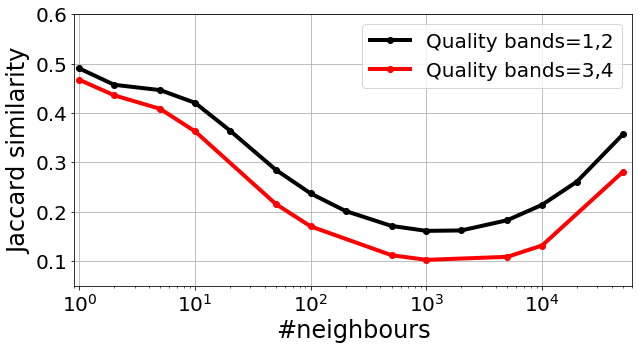

In [40]:
plt.figure(figsize=(10, 5))


plt.plot(neigh_jaccard_bands_1_2[0][:, 0], np.mean(neigh_jaccard_bands_1_2, axis=0)[:, 1], 
         'k-o', alpha=1.0, 
         lw=4,
         label='Quality bands=1,2')

plt.plot(neigh_jaccard_bands_3_4[:, 0], neigh_jaccard_bands_3_4[:, 1], 
         'r-o', alpha=1.0, 
         lw=4,
         label='Quality bands=3,4')

plt.grid()
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("#neighbours", size=24)
plt.ylabel("Jaccard similarity", size=24)
plt.xscale("log")
plt.xlim(0.9, 60000)
plt.ylim(0.05, 0.6)

plt.legend(prop={'size': 20})
plt.show()
#plt.xlim(0, 20000)